In [4]:
!pip install varname
!pip install pydub
!pip install librosa

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ast import literal_eval

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import IPython.display as ipd

import requests
import os
from varname import argname
from pydub import AudioSegment
import librosa
import librosa.display

import pickle

In [5]:
mp3s = pd.read_csv('collection_1_mp3s.csv', index_col=0)

In [6]:
mp3s['artists'] = mp3s['artists'].map(lambda x: literal_eval(x))

In [7]:
mp3s[mp3s['track'] == "3 Headed Goat (feat. Lil Baby & Polo G)"]

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
2302,5BSUxDJ8HcOWZD2KfExs7b,42,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b27390715e...,169531,https://p.scdn.co/mp3-preview/0da58f96ee2d706e...
2343,7J7UEZ08wc5aDsHgYpf8zI,10,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273bdce61...,169531,https://p.scdn.co/mp3-preview/a016e90c7e1e4e32...
8601,14c8arYQPMtxPcF4L4FYXC,47,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273fec5f2...,169531,https://p.scdn.co/mp3-preview/e2e7d8016dfba565...
14639,6Tguhaf2uAe6OjRLsR2Tql,77,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b273f8558e...,169531,https://p.scdn.co/mp3-preview/2d01e3ab3d48b281...


In [8]:
# there are duplicate songs from different albums (single, album, etc.)
# if they have different popularity scores, that's still valuable info, however
mp3s[mp3s.duplicated(subset=['track','duration_ms','popularity'], 
                     keep=False)]['track'].value_counts()

Back In Blood (feat. Lil Durk)         2
SAME THING                             2
Quarantine Speech                      2
Green Tea & Honey                      2
8 Figures                              2
80's - Instrumental - Remastered       2
Xta6                                   2
hooligan                               2
Amen (feat. Kevin Gates)               2
4N (feat. Mach-Hommy)                  2
50/50 Love                             2
1988 REMAKE 2_Nottz_42North.wav        2
Seven Day Hustle                       2
Just Mellow - Norman Cook 7'' Remix    2
X-Ray                                  2
6565                                   2
Name: track, dtype: int64

In [9]:
mp3s.shape

(12938, 10)

In [10]:
mp3s.drop_duplicates(subset=['track','duration_ms','popularity'], inplace=True)
mp3s.shape

(12922, 10)

In [11]:
# making train test holdout splits

X = mp3s.drop(columns=['popularity'])
y = mp3s['popularity']

X_pretr, X_holdout, y_pretr, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pretr, y_pretr, 
                                                    test_size=15/90, random_state=42)
print(X_train.shape, X_test.shape, X_holdout.shape)

(9690, 9) (1939, 9) (1293, 9)


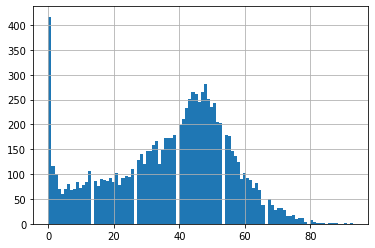

In [12]:
# 39 seems to be a good cutoff
y_train.hist(bins=100)

In [13]:
# defining popular as >= 39 and encoding (1 = popular)
y_train = y_train.map(lambda x: 1 if x >= 39 else 0)
y_train.value_counts(normalize=True)

1    0.540557
0    0.459443
Name: popularity, dtype: float64

In [14]:
y_test = y_test.map(lambda x: 1 if x >= 39 else 0)
y_test.value_counts(normalize=True)

1    0.554409
0    0.445591
Name: popularity, dtype: float64

In [15]:
y_holdout = y_holdout.map(lambda x: 1 if x >= 39 else 0)
y_holdout.value_counts(normalize=True)

1    0.539056
0    0.460944
Name: popularity, dtype: float64

In [16]:
def get_mp3(http, directory, name):
    try:
        r = requests.get(http, timeout=2)
        with open(f'{directory}/{name}.mp3', 'wb') as f:
            f.write(r.content)
        print(f'mp3 acquision: {name}.mp3')
    except:
        print(f'mp3 timeout: index {name}')

In [17]:
class LibrosaProcessing:
    def __init__(self, split, data, target):
        self.data_ = data.copy()
        self.target_ = target.copy()
        wd = !pwd
        self.directory_ = f'{wd[0]}/data/{split}'
        print("wd[0]: ", wd[0])
        if not os.path.exists(self.directory_):
            os.mkdir(self.directory_)
        self.mp3_directory_ = f'{self.directory_}/mp3'
        self.wav_directory_ = f'{self.directory_}/wav'

    def get_mp3(self):
        if not os.path.exists(self.mp3_directory_):
            os.mkdir(self.mp3_directory_)
        self.data_['preview_url'].reset_index().apply(lambda x: get_mp3(x[1],
                                                                         self.mp3_directory_,
                                                                         x[0]), axis=1)
        print('mp3s acquired')
        
    def get_wav(self):
        if not os.path.exists(self.wav_directory_):
            os.mkdir(self.wav_directory_)
        for file in os.listdir(self.mp3_directory_):
            src = f'{self.mp3_directory_}/{file}'
            dest = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            AudioSegment.from_mp3(src).export(dest, format='wav')
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = dest
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()
    
    def get_wav_path(self):
        for file in os.listdir(self.wav_directory_):
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = f'{self.wav_directory_}/{file}'
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()

    def get_mel_spec(self):
        self.specs_pre_ = []
        self.spaxmax1_ = 128 # max size in dimension 1 for X_train
        self.spaxmax2_ = 1292 # max size in dimension 2 for X_train
        for count, song in enumerate(self.wav_, start=1):
            y, sr = librosa.load(song, duration=30)
            spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y,sr=sr), ref=np.min)
            self.specs_pre_.append(spec[np.newaxis, ..., np.newaxis])
            print(f"wavs run: {count}/{len(self.wav_)}")
        resized = []
        for spec in self.specs_pre_:
            resized.append(np.resize(spec, (1, self.spaxmax1_, self.spaxmax2_, 1)))
        self.mel_specs_ = np.concatenate(resized, axis=0)
        return (self.mel_specs_, self.target_)
    
    def get_mfcc(self):
        pass
#         librosa.        
#         return 

In [20]:
n = 100
X_train_small = X_train.iloc[:n,:];  y_train_small = y_train[:n]
X_test_small = X_test.iloc[:n,:]; y_test_small = y_test[:n]
X_holdout_small = X_holdout.iloc[:n,:]; y_holdout_small = y_holdout[:n]
raw_datadict = {'X_train': (X_train_small, y_train_small), 
            'X_test': (X_test_small, y_test_small),
            'X_holdout': (X_holdout_small, y_holdout_small)}

In [30]:
with open('mel_spec_dict.pkl', 'rb') as up:
    mel_spec_datadict = pickle.load(up)

FileNotFoundError: ignored

In [31]:
mel_spec_datadict.keys()

NameError: ignored

In [32]:
mel_spec_datadict['X_holdout'][0].shape

NameError: ignored

In [23]:
mel_spec_datadict = {}
for i, (split, info) in enumerate(raw_datadict.items()):
    if split == 'X_train':
        lp = LibrosaProcessing(split, info[0], info[1])
        lp.get_mp3()
        lp.get_wav()
        mel_spec_datadict[split] = lp.get_mel_spec()
    if split == 'X_test':
        lp2 = LibrosaProcessing(split, info[0], info[1])
        lp2.get_mp3()
        lp2.get_wav()
        mel_spec_datadict[split] = lp2.get_mel_spec()
    if split == 'X_holdout':
        lp3 = LibrosaProcessing(split, info[0], info[1])
        lp3.get_mp3()
        lp3.get_wav()
        mel_spec_datadict[split] = lp3.get_mel_spec()

wd[0]:  /content
mp3 acquision: 9784.mp3
mp3 acquision: 582.mp3
mp3 acquision: 4879.mp3
mp3 acquision: 6576.mp3
mp3 acquision: 4520.mp3
mp3 acquision: 8721.mp3
mp3 acquision: 16180.mp3
mp3 acquision: 12549.mp3
mp3 acquision: 8259.mp3
mp3 acquision: 6395.mp3
mp3 acquision: 11543.mp3
mp3 acquision: 1017.mp3
mp3 acquision: 9500.mp3
mp3 acquision: 8950.mp3
mp3 acquision: 7207.mp3
mp3 acquision: 10464.mp3
mp3 acquision: 16160.mp3
mp3 acquision: 717.mp3
mp3 acquision: 752.mp3
mp3 acquision: 11368.mp3
mp3 acquision: 16107.mp3
mp3 acquision: 16694.mp3
mp3 acquision: 3583.mp3
mp3 acquision: 5863.mp3
mp3 timeout: index 126
mp3 acquision: 14015.mp3
mp3 acquision: 9572.mp3
mp3 acquision: 12444.mp3
mp3 acquision: 7566.mp3
mp3 acquision: 1974.mp3
mp3 acquision: 3423.mp3
mp3 acquision: 6290.mp3
mp3 acquision: 6452.mp3
mp3 acquision: 11803.mp3
mp3 acquision: 15163.mp3
mp3 acquision: 1589.mp3
mp3 acquision: 8935.mp3
mp3 acquision: 14150.mp3
mp3 acquision: 1891.mp3
mp3 acquision: 12902.mp3
mp3 acquision

In [24]:
with open('mel_spec_dict.pkl', 'wb') as p:
    pickle.dump(mel_spec_datadict, p)

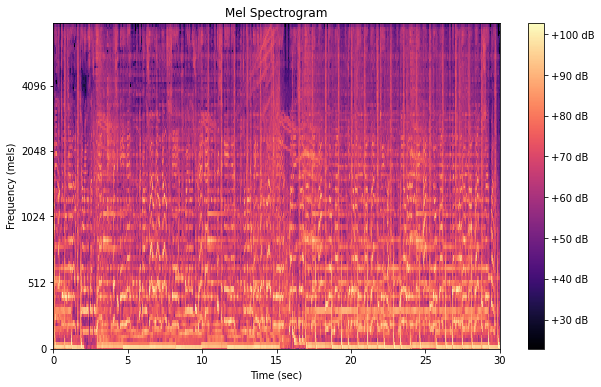

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
idx = 90
img = librosa.display.specshow(lp.specs_pre_[idx][0,:,:,0], x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [ ]:
y, sr = librosa.load(lp.wav_.iloc[0],duration=30)
ipd.Audio(y,rate=sr)

In [1]:
class MinMaxScaler:
    def fit(self, X_train):
        self.X_train_ = X_train
        self.max_ = self.X_train_.max()
        self.min_ = self.X_train_.min()
        
    def transform(self, X):
        return (X - self.min_) / (self.max_ - self.min_)
        

In [2]:
# Scaling
mm = MinMaxScaler()
mm.fit(mel_spec_datadict['X_train'][0])

mel_spec_sc = {}
for split, info in mel_spec_datadict.items():
    scaledX = mm.transform(info[0])
    mel_spec_sc[split] = (scaledX, info[1])


NameError: ignored

In [ ]:
mel_spec_sc['X_test'][1].shape

(2426,)

In [ ]:
with open('mel_spec_sc.pkl', 'wb') as p:
    pickle.dump(mel_spec_sc, p)